<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

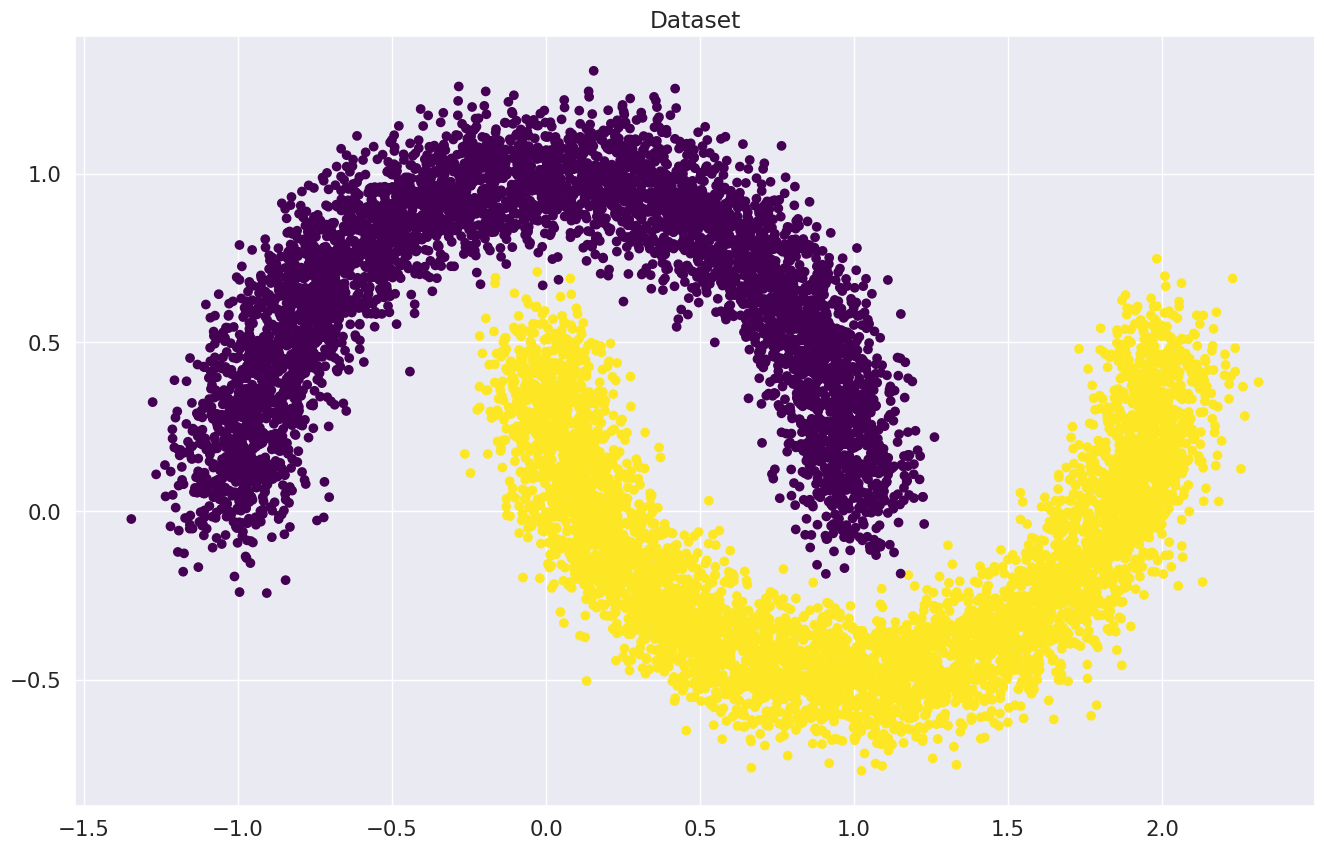

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [38]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[ 0.3221],
         [-1.5605]], requires_grad=True),
 Parameter containing:
 tensor([-1.2293], requires_grad=True)]

Всего три параметра (общая формула $(in\_features + 1)out\_features$)

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp, y_batch[:,None].to(torch.float16))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5546875
Iteration: 100
Batch accuracy: 0.8515625
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.90625

Iteration: 519.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**  519

### Визуализируем результаты

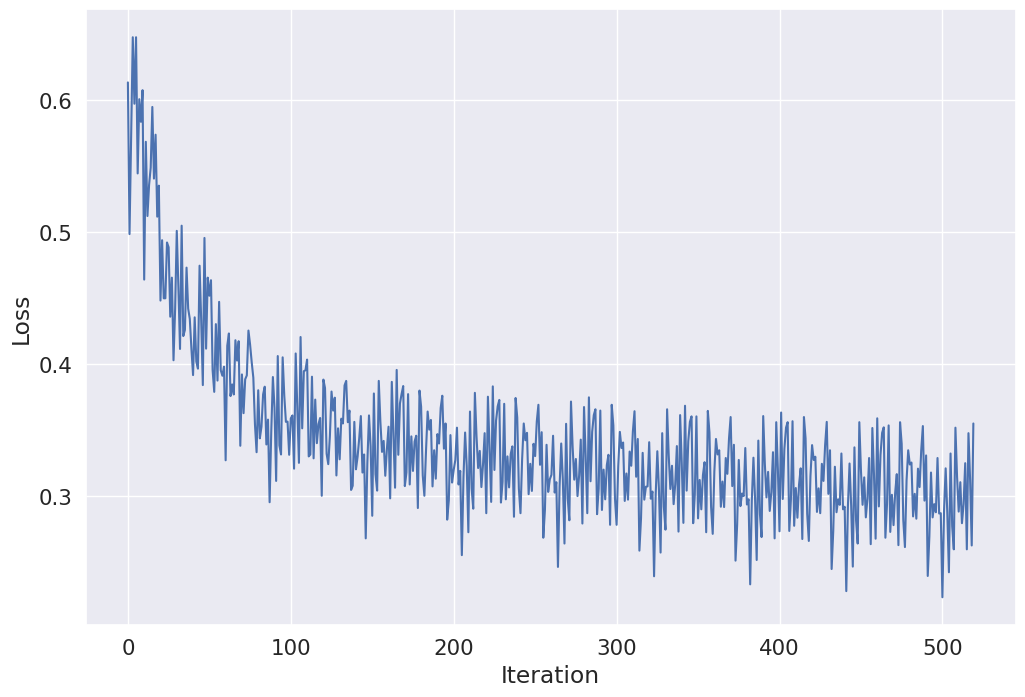

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

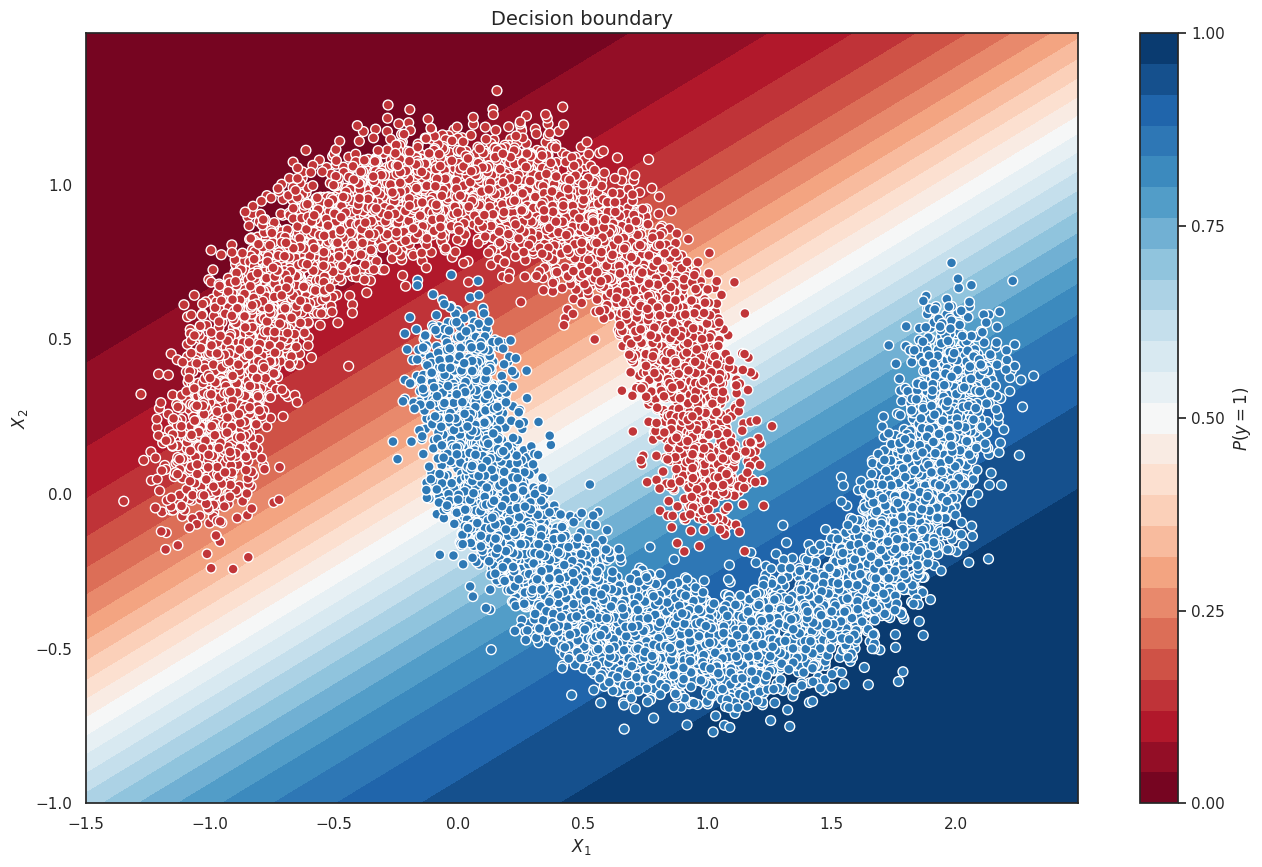

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = (torch.sigmoid(model(x_batch)) > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score

X_test, y_test = make_moons(n_samples=10000, random_state=15, noise=0.1)

test_dataloader = DataLoader(TensorDataset(
    torch.FloatTensor(X_test),
    torch.LongTensor(y_test)
))

accuracy_score(y_test, predict(test_dataloader, linear_regression))

0.8532

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8532

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [44]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
valid_dataloader =  DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [115]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=10),
    nn.Softmax(dim=1)
)

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [117]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                model.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8550833333333333
Loader: valid. Accuracy: 0.9171
Epoch: 2
Loader: train. Accuracy: 0.9256166666666666
Loader: valid. Accuracy: 0.9389
Epoch: 3
Loader: train. Accuracy: 0.94225
Loader: valid. Accuracy: 0.9472
Epoch: 4
Loader: train. Accuracy: 0.9495166666666667
Loader: valid. Accuracy: 0.952
Epoch: 5
Loader: train. Accuracy: 0.9571333333333333
Loader: valid. Accuracy: 0.9506
Epoch: 6
Loader: train. Accuracy: 0.9599333333333333
Loader: valid. Accuracy: 0.9558
Epoch: 7
Loader: train. Accuracy: 0.9621833333333333
Loader: valid. Accuracy: 0.9631
Epoch: 8
Loader: train. Accuracy: 0.9663333333333334
Loader: valid. Accuracy: 0.9688
Epoch: 9
Loader: train. Accuracy: 0.96845
Loader: valid. Accuracy: 0.9598
Epoch: 10
Loader: train. Accuracy: 0.9707166666666667
Loader: valid. Accuracy: 0.9595


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [118]:
elu_accuracy = accuracy["valid"]

In [119]:
def test_activation_function(activation):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=10),
        nn.Softmax(dim=1)
    )
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in tqdm(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    model.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [121]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8541333333333333
Loader: valid. Accuracy: 0.8922
Epoch: 2
Loader: train. Accuracy: 0.8911666666666667
Loader: valid. Accuracy: 0.9018
Epoch: 3
Loader: train. Accuracy: 0.8950333333333333
Loader: valid. Accuracy: 0.9036
Epoch: 4
Loader: train. Accuracy: 0.8962333333333333
Loader: valid. Accuracy: 0.9094
Epoch: 5
Loader: train. Accuracy: 0.8945833333333333
Loader: valid. Accuracy: 0.8852
Epoch: 6
Loader: train. Accuracy: 0.8946
Loader: valid. Accuracy: 0.906
Epoch: 7
Loader: train. Accuracy: 0.8969166666666667
Loader: valid. Accuracy: 0.8953
Epoch: 8
Loader: train. Accuracy: 0.8944833333333333
Loader: valid. Accuracy: 0.893
Epoch: 9
Loader: train. Accuracy: 0.8926333333333333
Loader: valid. Accuracy: 0.8947
Epoch: 10
Loader: train. Accuracy: 0.8946166666666666
Loader: valid. Accuracy: 0.8994


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.7246166666666667
Loader: valid. Accuracy: 0.7524
Epoch: 2
Loader: train. Accuracy: 0.8609666666666667
Loader: valid. Accuracy: 0.923
Epoch: 3
Loader: train. Accuracy: 0.9306
Loader: valid. Accuracy: 0.9348
Epoch: 4
Loader: train. Accuracy: 0.9437333333333333
Loader: valid. Accuracy: 0.948
Epoch: 5
Loader: train. Accuracy: 0.9515666666666667
Loader: valid. Accuracy: 0.9544
Epoch: 6
Loader: train. Accuracy: 0.9569666666666666
Loader: valid. Accuracy: 0.9568
Epoch: 7
Loader: train. Accuracy: 0.9601333333333333
Loader: valid. Accuracy: 0.9587
Epoch: 8
Loader: train. Accuracy: 0.9644
Loader: valid. Accuracy: 0.9599
Epoch: 9
Loader: train. Accuracy: 0.9654
Loader: valid. Accuracy: 0.9652
Epoch: 10
Loader: train. Accuracy: 0.9676833333333333
Loader: valid. Accuracy: 0.9598


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8478333333333333
Loader: valid. Accuracy: 0.9134
Epoch: 2
Loader: train. Accuracy: 0.9207333333333333
Loader: valid. Accuracy: 0.9338
Epoch: 3
Loader: train. Accuracy: 0.9384
Loader: valid. Accuracy: 0.9452
Epoch: 4
Loader: train. Accuracy: 0.9484
Loader: valid. Accuracy: 0.9516
Epoch: 5
Loader: train. Accuracy: 0.9560166666666666
Loader: valid. Accuracy: 0.9555
Epoch: 6
Loader: train. Accuracy: 0.959
Loader: valid. Accuracy: 0.9629
Epoch: 7
Loader: train. Accuracy: 0.9632666666666667
Loader: valid. Accuracy: 0.9602
Epoch: 8
Loader: train. Accuracy: 0.9648166666666667
Loader: valid. Accuracy: 0.9639
Epoch: 9
Loader: train. Accuracy: 0.965
Loader: valid. Accuracy: 0.9566
Epoch: 10
Loader: train. Accuracy: 0.9667833333333333
Loader: valid. Accuracy: 0.9654


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

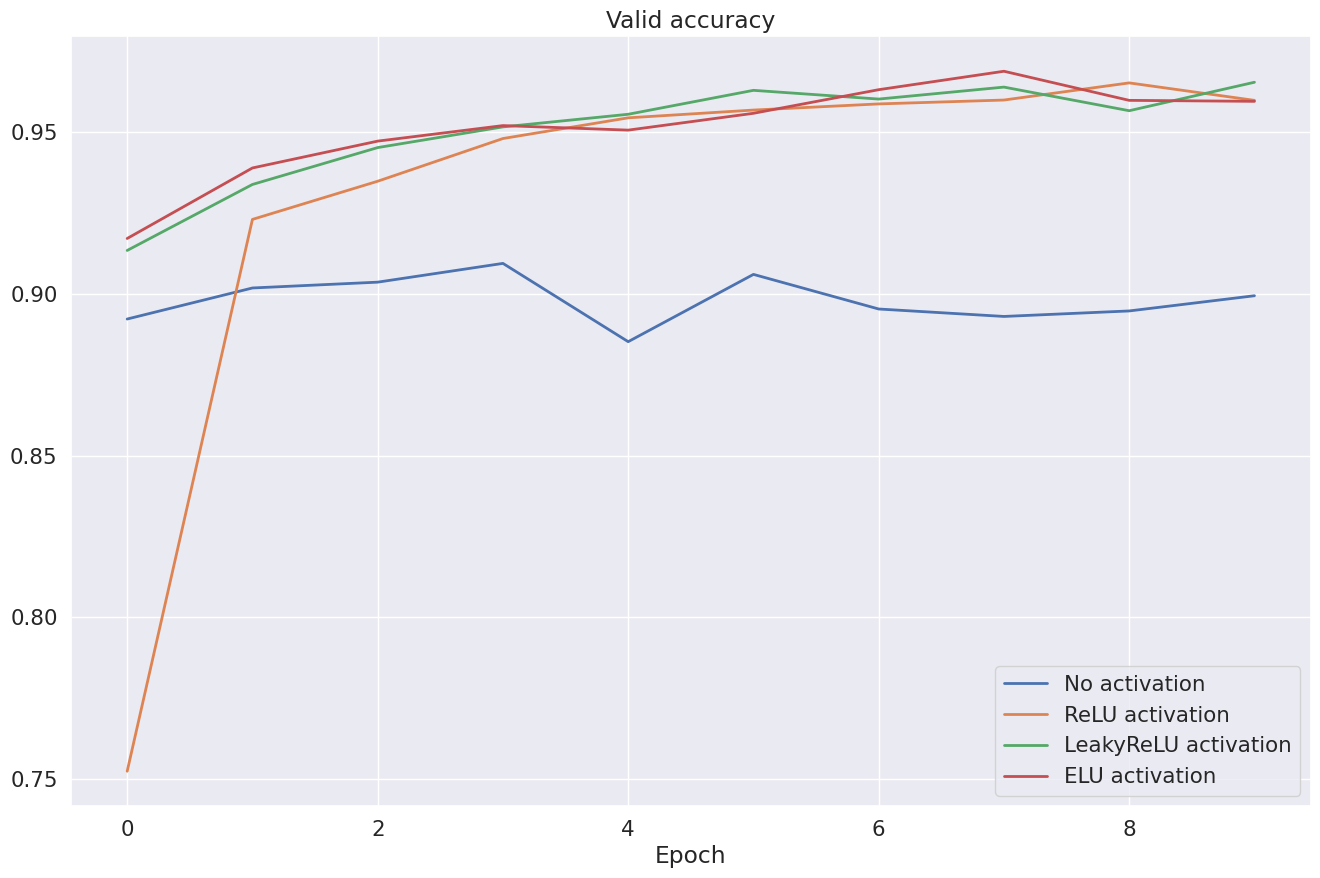

In [125]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

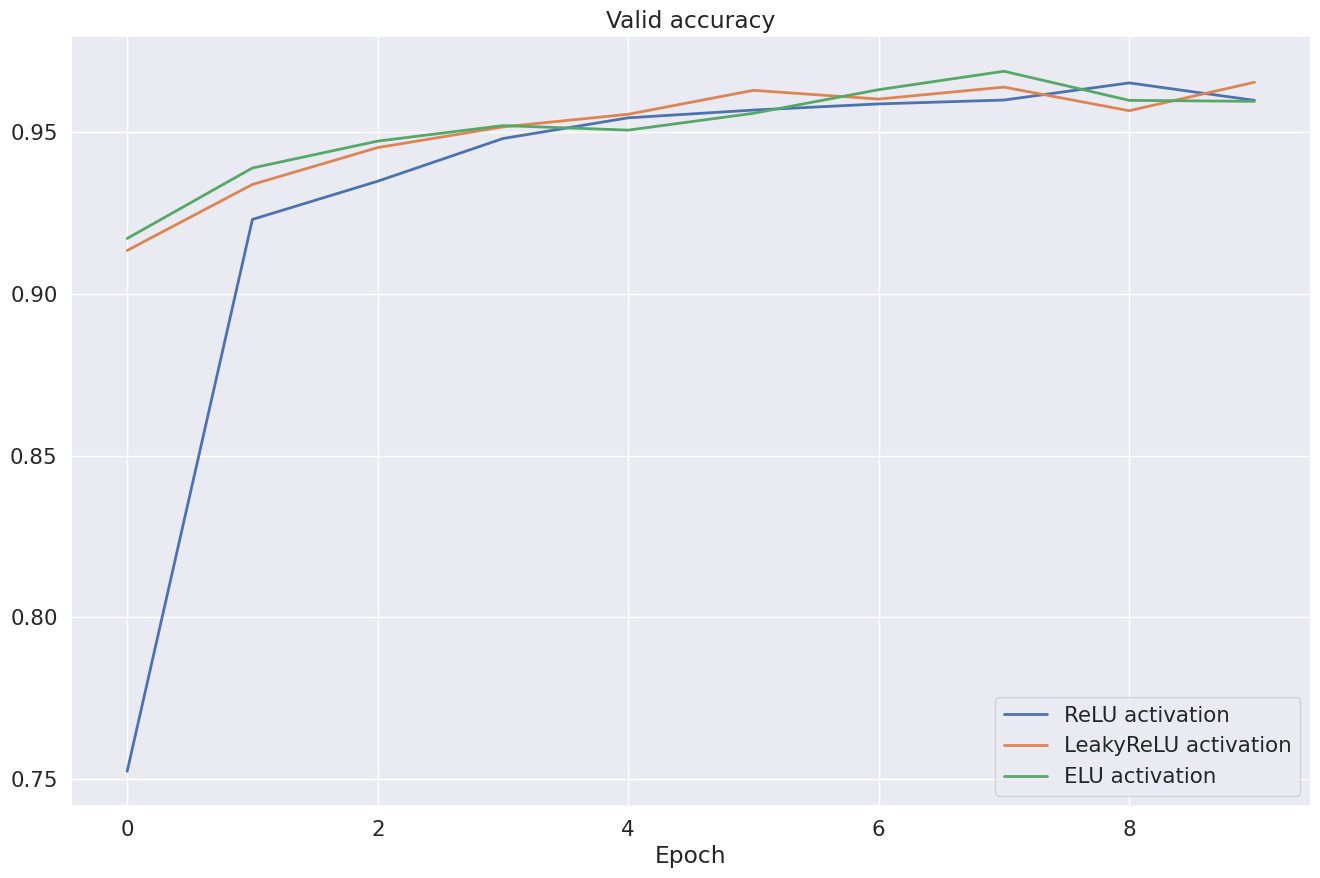

In [126]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Leaky ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [127]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-02 10:13:31--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-02 10:13:32--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3030::6815:15c, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.006s  

2023-04-02 10:13:32 (8.

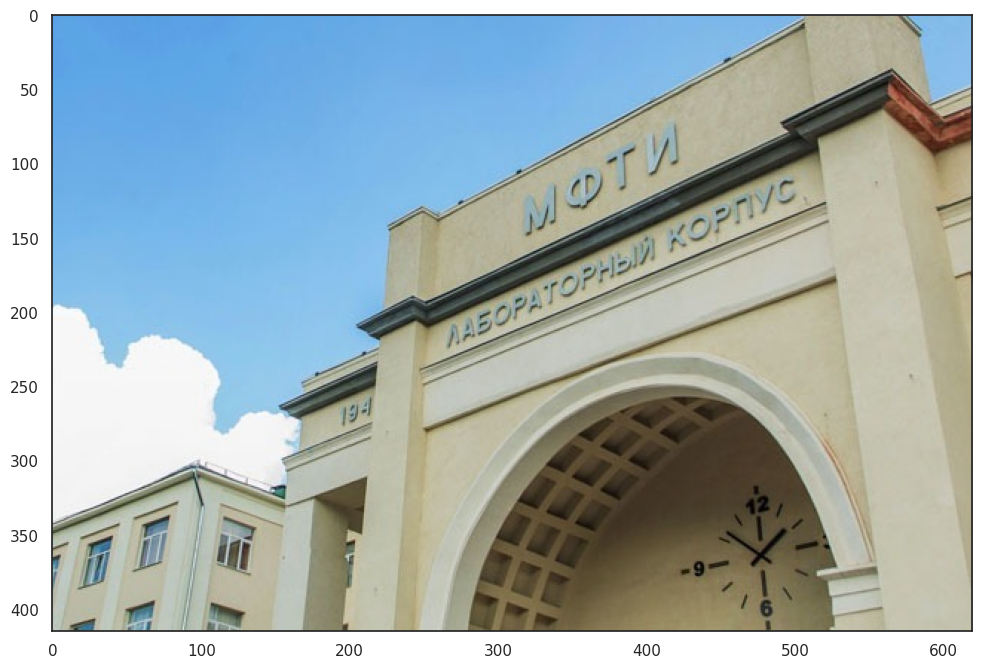

In [128]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [131]:
def conv(kernel):
  img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
  kernel = kernel.reshape(1, 1, 3, 3).type(torch.float32)

  kernel = kernel.repeat(3, 3, 1, 1)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

  return F.conv2d(img_t, kernel)[0]  #

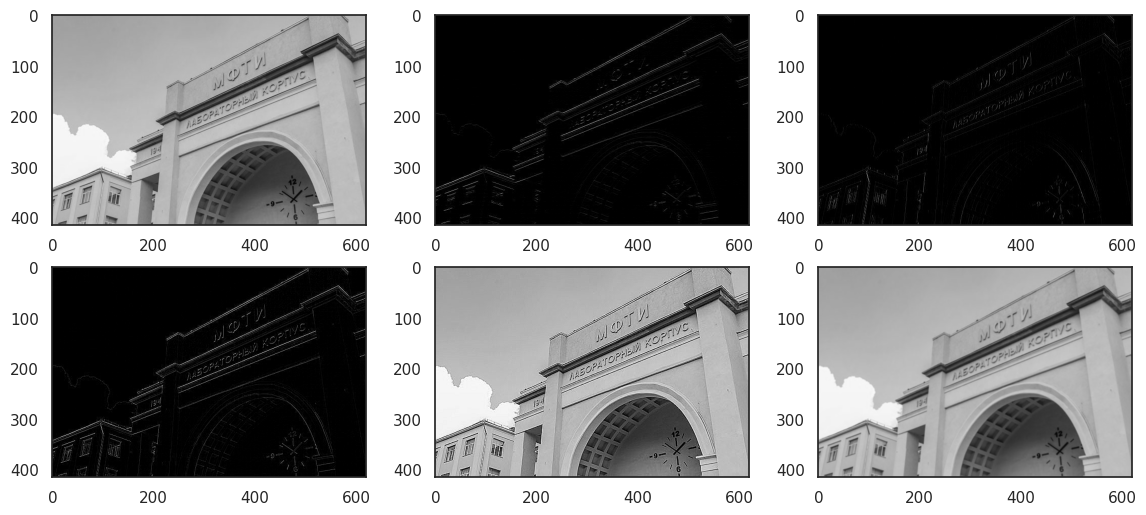

In [136]:
#plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(2, 3, figsize=(14, 6))

result_np = conv(torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])).permute(1, 2, 0).numpy() / 256 / 3

ax[0][0].imshow(result_np)

result_np = conv(torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
])).permute(1, 2, 0).numpy() / 256 / 3

ax[0][1].imshow(result_np)

result_np = conv(torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
])).permute(1, 2, 0).numpy() / 256 / 3

ax[0][2].imshow(result_np)

result_np = conv(torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])).permute(1, 2, 0).numpy() / 256 / 3

ax[1][0].imshow(result_np)

result_np = conv(torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])).permute(1, 2, 0).numpy() / 256 / 3

ax[1][1].imshow(result_np)

result_np = conv(torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
])).permute(1, 2, 0).numpy() / 256 / 3

ax[1][2].imshow(result_np)

plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**  
1 Е,
2 Д,
3 А,
4 Б,
5 В,
6 Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [184]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=400, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # x [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # x [batch_size, 6, 26, 26]
        x = self.pool1(x)
        # x [batch_size, 6, 13, 13]
        x = F.relu(self.conv2(x))
        # x [batch_size, 16, 11, 11]
        x = self.pool2(x)
        # x [batch_size, 16, 5, 5]
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        # x [batch_size, 400]
        x = F.relu(self.fc1(x))
        # x [batch_size, 120]
        x = F.relu(self.fc2(x))
        # x [batch_size, 84]
        x = self.fc3(x)
        # x [batch_size, 10]
        return x

In [185]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [186]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                model.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8854333333333333
Loader: valid. Accuracy: 0.9645
Epoch: 2
Loader: train. Accuracy: 0.9710666666666666
Loader: valid. Accuracy: 0.9778
Epoch: 3
Loader: train. Accuracy: 0.9808666666666667
Loader: valid. Accuracy: 0.9818
Epoch: 4
Loader: train. Accuracy: 0.9852333333333333
Loader: valid. Accuracy: 0.9858
Epoch: 5
Loader: train. Accuracy: 0.9876333333333334
Loader: valid. Accuracy: 0.9859
Epoch: 6
Loader: train. Accuracy: 0.98925
Loader: valid. Accuracy: 0.9878
Epoch: 7
Loader: train. Accuracy: 0.9907
Loader: valid. Accuracy: 0.9848
Epoch: 8
Loader: train. Accuracy: 0.9922333333333333
Loader: valid. Accuracy: 0.9882
Epoch: 9
Loader: train. Accuracy: 0.9929666666666667
Loader: valid. Accuracy: 0.9893
Epoch: 10
Loader: train. Accuracy: 0.9939833333333333
Loader: valid. Accuracy: 0.9876


In [187]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

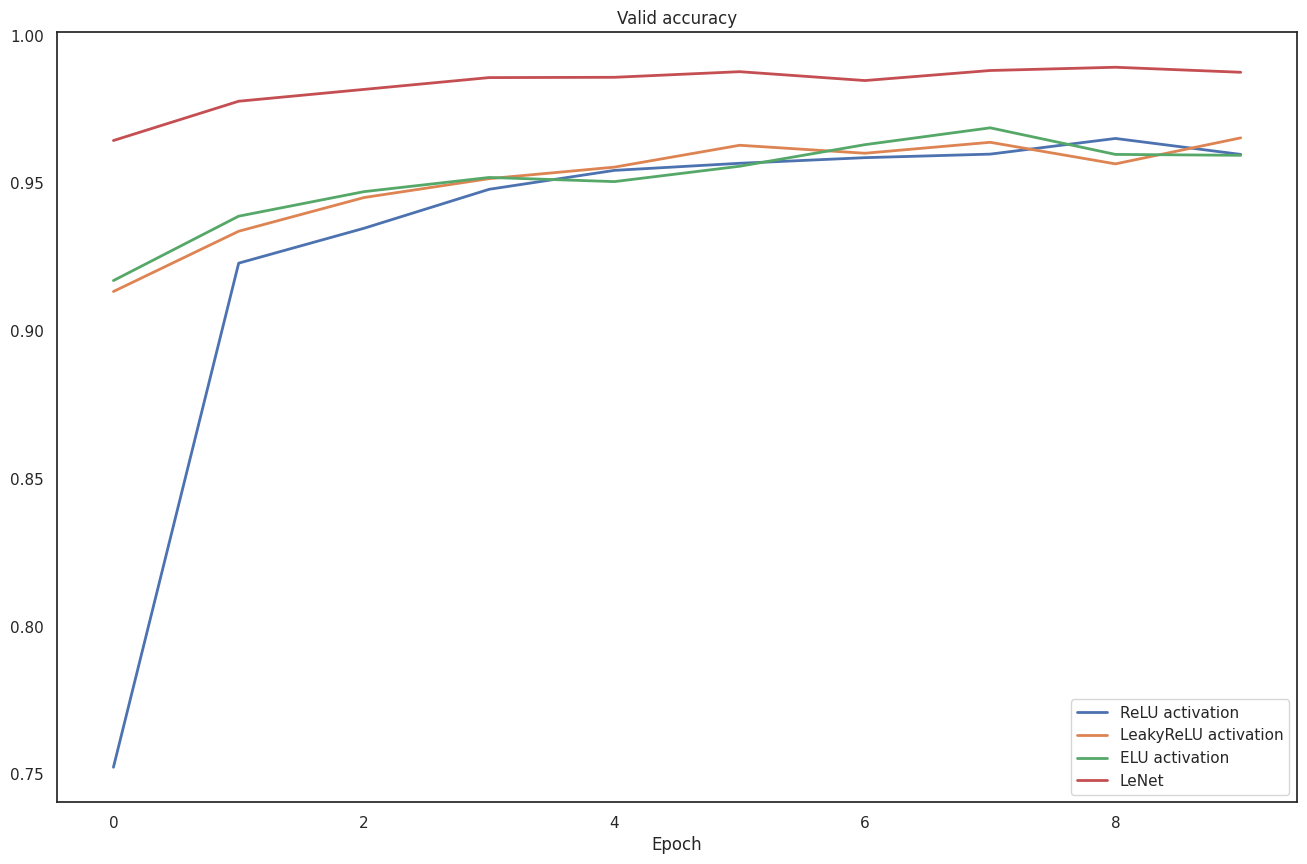

In [188]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**  0.99